In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
# Загрузка датасета
data = od.download(
    "https://www.kaggle.com/datasets/andrewmvd/doom-crossing/data")

Skipping, found downloaded files in "./doom-crossing" (use force=True to force download)


In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

doom_color = '#B9121B'
ac_color = '#3CAEA3'

initial_epochs = 10

Batch Size: 32
Image Shape: (64, 64, 3)


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/doom-crossing', image_size=(IMG_WIDTH, IMG_HEIGHT))

data = data.map(lambda x,y: (x/255, y))

Found 1597 files belonging to 2 classes.


In [ ]:
train_size_percentage = 0.7
val_size_percentage = 0.2
test_size_percentage = 0.1

spared_batches = len(data) % 10

train_size = int(len(data) * train_size_percentage)
val_size = int(len(data) * val_size_percentage)
test_size = int(len(data) * test_size_percentage) + spared_batches


train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
def train_model(model, train, val, initial_epochs, callbacks):
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
      ]
    )

    hist = model.fit(train,
                     epochs=initial_epochs,
                     validation_data=val,
                     callbacks=[tensorboard_callback])

    # График функции потерь
    fig = plt.figure()
    plt.plot(hist.history['loss'], color=doom_color, label='loss')
    plt.plot(hist.history['val_loss'], color=ac_color, label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # График точности
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color=doom_color, label='accuracy')
    plt.plot(hist.history['val_accuracy'], color=ac_color, label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def test_model(model, test):
    y_true = []
    y_pred = []

    precision = Precision()
    recall = Recall()
    binary_accuracy = BinaryAccuracy()

    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)

        y_true.extend(y)
        y_pred.extend((yhat > 0.5).astype(int))

        precision.update_state(y, yhat)
        recall.update_state(y, yhat)
        binary_accuracy.update_state(y, yhat)

    print(f'Precision: {precision.result():.2f}, Recall: {recall.result():.2f}, Binary Accuracy: {binary_accuracy.result():.2f}')

    cm = confusion_matrix(y_true, y_pred)
    labels = test.class_names if hasattr(test, 'class_names') else ['class_0', 'class_1']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

LSTM модель

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SHAPE),
    tf.keras.layers.Reshape((64, 64*3)),

    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5316 - loss: 0.6930 - precision: 0.3257 - recall: 0.0540 - val_accuracy: 0.5906 - val_loss: 0.6923 - val_precision: 0.5938 - val_recall: 0.8492
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5344 - loss: 0.6926 - precision: 0.5197 - recall: 0.7525 - val_accuracy: 0.6438 - val_loss: 0.6913 - val_precision: 0.6398 - val_recall: 0.7169
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6192 - loss: 0.6909 - precision: 0.6412 - recall: 0.5399 - val_accuracy: 0.6219 - val_loss: 0.6842 - val_precision: 0.7647 - val_recall: 0.3916
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5730 - loss: 0.6801 - precision: 0.6131 - recall: 0.4810 - val_accuracy: 0.6125 - val_loss: 0.6609 - val_precision: 0.6912 - val_recall: 0.5341
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5961 - loss: 0.6690 - precision: 0.6351 - recall: 0.5088 - val_accuracy: 0.6375 - val_loss: 0.6514 - val

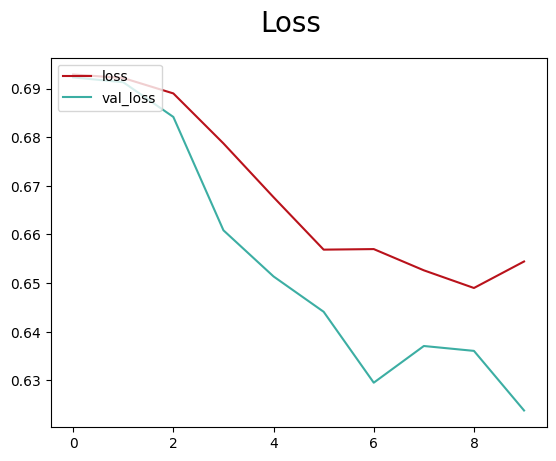

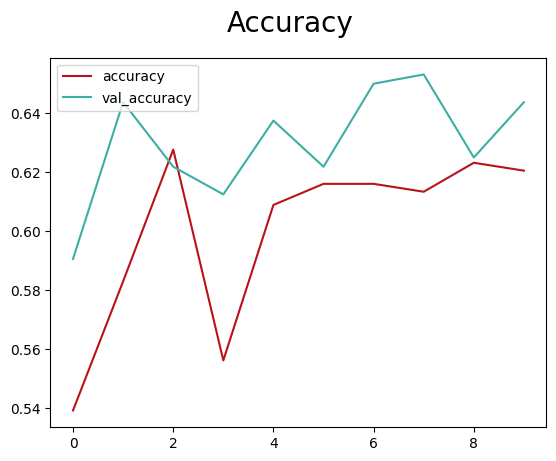

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Precision: 0.64, Recall: 0.52, Binary Accuracy: 0.57


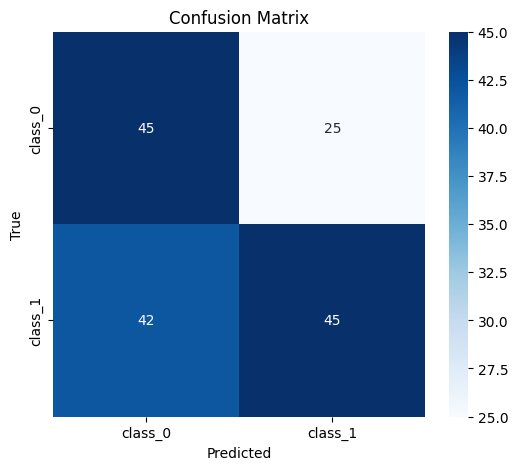

In [ ]:
train(model1, train, val, initial_epochs, tensorboard_callback)

In [ ]:
test_model(model1, test)

Двухслоуйная LSTM модель

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SHAPE),

    tf.keras.layers.Reshape((64, 64*3)),

    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5053 - loss: 0.6931 - precision: 0.5111 - recall: 0.5082 - val_accuracy: 0.6375 - val_loss: 0.6927 - val_precision: 0.6727 - val_recall: 0.6416
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.5899 - loss: 0.6926 - precision: 0.5850 - recall: 0.6835 - val_accuracy: 0.6438 - val_loss: 0.6901 - val_precision: 0.6840 - val_recall: 0.7940
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6086 - loss: 0.6895 - precision: 0.5963 - recall: 0.7015 - val_accuracy: 0.6125 - val_loss: 0.6507 - val_precision: 0.6261 - val_recall: 0.7912
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5868 - loss: 0.6703 - precision: 0.6030 - recall: 0.5451 - val_accuracy: 0.6438 - val_loss: 0.6287 - val_precision: 0.7020 - val_recall: 0.6057
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6023 - loss: 0.6595 - precision: 0.6516 - recall: 0.4938 - val_accuracy: 0.6187 - val_loss: 0.6364 - val

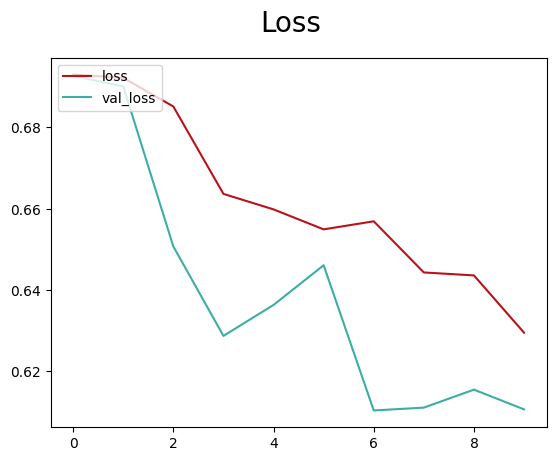

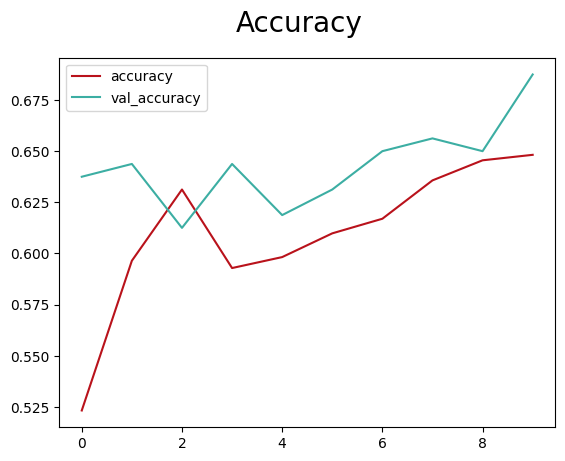

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Precision: 0.70, Recall: 0.60, Binary Accuracy: 0.65


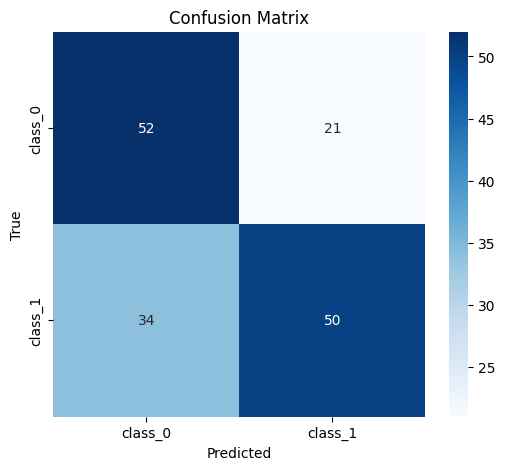

In [ ]:
train_model(model2, train, val, initial_epochs, tensorboard_callback)

In [ ]:
test_model(model2, test)

GRU модель

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SHAPE),

    tf.keras.layers.Reshape((64, 64*3)),

    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.5423 - loss: 0.6931 - precision: 0.5810 - recall: 0.3220 - val_accuracy: 0.5125 - val_loss: 0.6925 - val_precision: 0.5204 - val_recall: 0.9107
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.4852 - loss: 0.6927 - precision: 0.4956 - recall: 0.8877 - val_accuracy: 0.5500 - val_loss: 0.6913 - val_precision: 0.5638 - val_recall: 0.9231
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5261 - loss: 0.6925 - precision: 0.5147 - recall: 0.7753 - val_accuracy: 0.5688 - val_loss: 0.6909 - val_precision: 0.5744 - val_recall: 0.7989
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5230 - loss: 0.6914 - precision: 0.5214 - recall: 0.7695 - val_accuracy: 0.5250 - val_loss: 0.6900 - val_precision: 0.5233 - val_recall: 0.8232
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.5379 - loss: 0.6903 - precision: 0.5287 - recall: 0.7178 - val_accuracy: 0.6875 - val_loss: 0.6801 - val

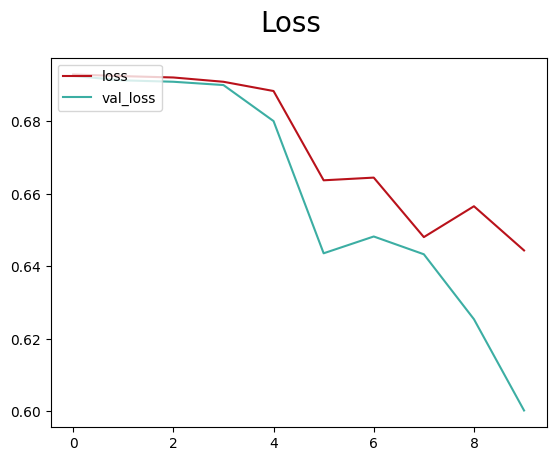

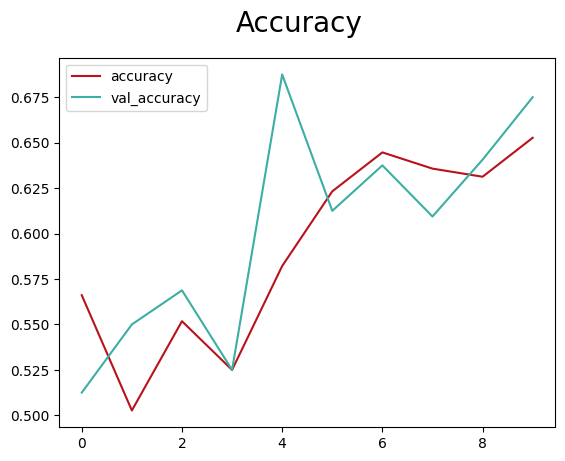

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Precision: 0.72, Recall: 0.66, Binary Accuracy: 0.65


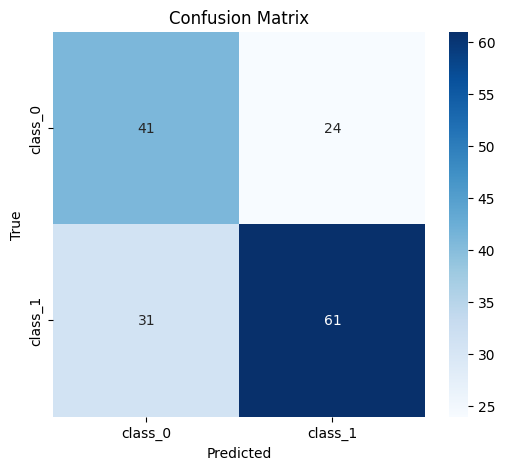

In [ ]:
train_model(model3, train, val, initial_epochs, tensorboard_callback)

In [ ]:
test_model(model3, test)

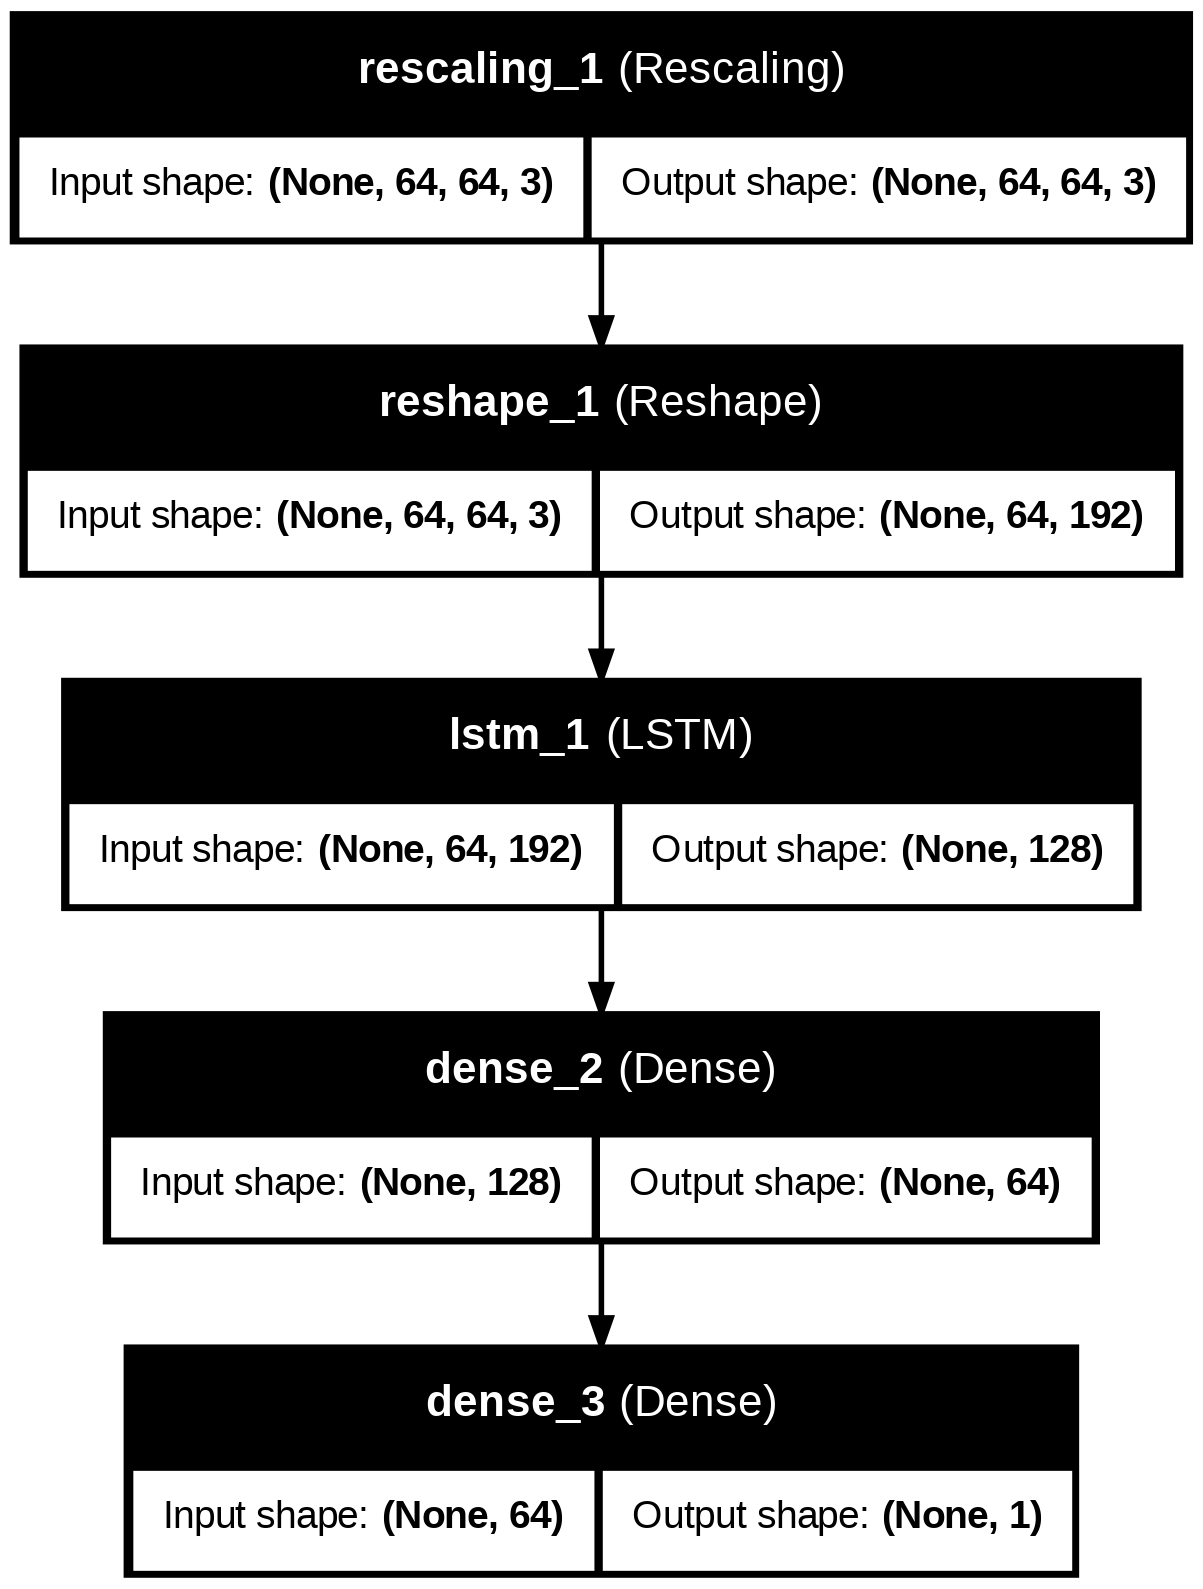

In [ ]:
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)
Image(filename='model1.png')

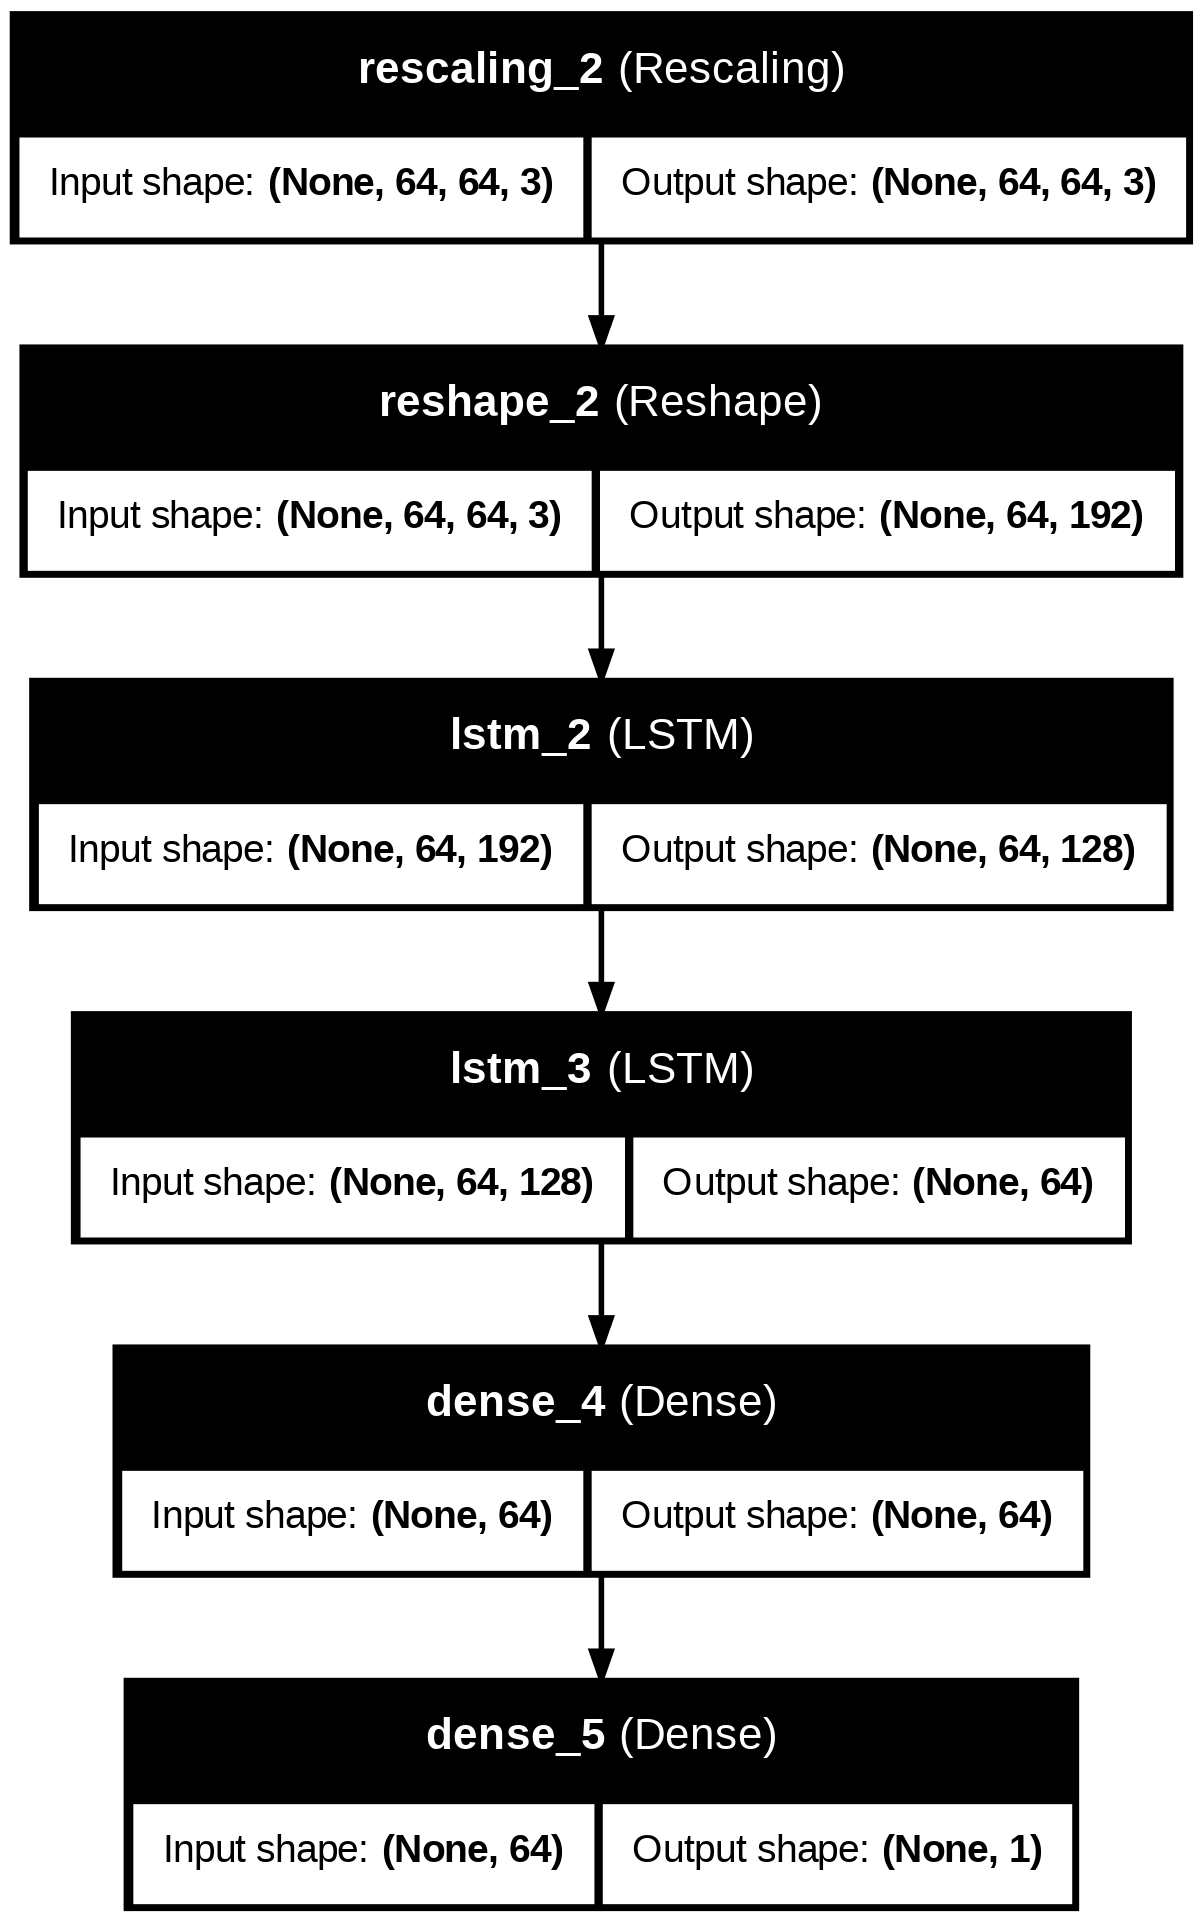

In [ ]:
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)
Image(filename='model2.png')

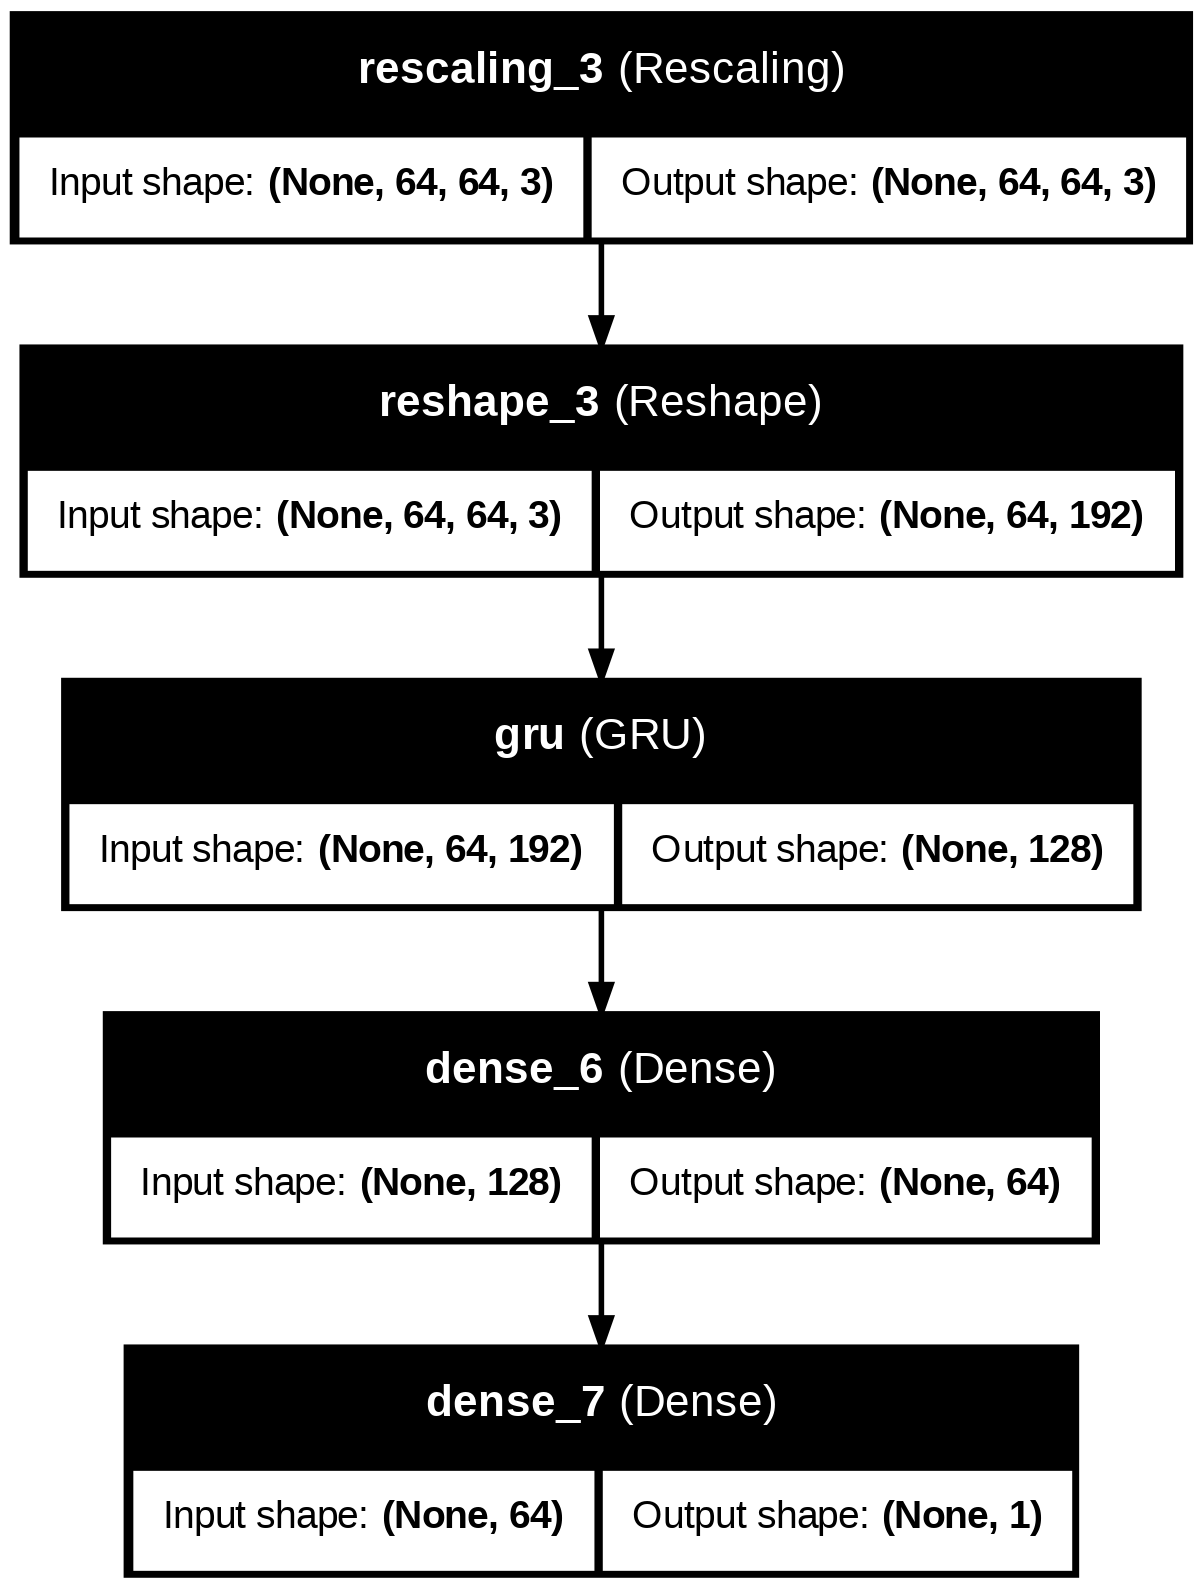

In [ ]:
plot_model(model3, to_file='model3.png', show_shapes=True, show_layer_names=True)
Image(filename='model3.png')